### Test the rectifier functions

In [1]:
from pathlib import Path
import imageio
import fsspec
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Notes
 * Metadata is a temporary dict of stuff that the Axiom code reads from files. 
 * extrinsic and intrinsic parameters are stored in a list of dicts
 * `metadata['coordinate_system']` indicates whether extrinsics are in local `'xyz'` or world `'geo'` coordinates
 
 * `lcp` is a dict of lens calibration parameters, a synonym for intrinsics
 * `beta` is an numpy array that contains the values of the extrinsic dict

In [2]:
# These .py files define the objects that load calibration data and do the rectification
# %run -i coastcam_funcs.py
# %run -i calibration_crs.py
# %run -i chs_rectifier_crs.py
from coastcam_funcs import *
from calibration_crs import *
from rectifier_crs import *

C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [3]:
# List of files...three for each camera. Calibration parameters are in .json format
# These are the USGS image filename format
extrinsic_cal_files = ['CACO01_C1_EOBest.json','CACO01_C2_EOBest.json']
intrinsic_cal_files = ['CACO01_C1_IOBest.json','CACO01_C2_IOBest.json']

In [4]:
s3 = False # set to False to test local read, set to True to test bucket read
if s3:
    # read from S3 bucket
    imdir='cmgp-coastcam/cameras/caco-01/products/'
    image_files = ['1600866001.c1.timex.jpg','1600866001.c2.timex.jpg']
    ftime = filetime2timestr(image_files[0], timezone='eastern')
    fs = fsspec.filesystem('s3')
else:
    # local test files
    imdir='./'
    image_files = ['1581508801.c1.timex.jpg','1581508801.c2.timex.jpg']
    ftime, e = filetime2timestr(image_files[0], timezone='eastern')

    fs = None

impaths = []
for f in image_files:
    impaths.append(imdir+f)
impaths

['./1581508801.c1.timex.jpg', './1581508801.c2.timex.jpg']

In [5]:
print(ftime, e)

2020-02-12 12:00:00 1581508801


In [6]:
# Dict providing the metadata that the Axiom code infers from the USACE filename format
metadata= {'name': 'CACO-01', 'serial_number': 1, 'camera_number': 'C1', 'calibration_date': '2019-12-12', 'coordinate_system': 'geo'}
# dict providing origin and orientation of the local grid
local_origin = {'x': 410935.,'y':4655890., 'angd': 55.}

In [7]:
# read cal files and make lists of cal dicts
extrinsics_list = []
for f in extrinsic_cal_files:
    extrinsics_list.append( json2dict(f) )
intrinsics_list = []
for f in intrinsic_cal_files:
    intrinsics_list.append( json2dict(f) )

In [8]:
# check test for coordinate system
if metadata['coordinate_system'].lower() == 'xyz':
    print('Extrinsics are local coordinates')
elif metadata['coordinate_system'].lower() == 'geo':
    print('Extrinsics are in world coordinates')
else:
    print('Invalid value of coordinate_system: ',metadata['coordinate_system'])
    
print(extrinsics_list[0])
print(extrinsics_list[0]['y']-local_origin['y'])

Extrinsics are in world coordinates
{'x': 410843.97, 'y': 4655942.49, 'z': 27.3, 'a': -0.271, 't': 1.304, 'r': 0.007}
52.49000000022352


In [9]:
calibration = CameraCalibration(metadata,intrinsics_list[0],extrinsics_list[0],local_origin)
print(calibration.local_origin)
print(calibration.world_extrinsics)
print(calibration.local_extrinsics)

{'x': 410935.0, 'y': 4655890.0, 'angd': 55.0}
{'x': 410843.97, 'y': 4655942.49, 'z': 27.3, 'a': -0.271, 't': 1.304, 'r': 0.007}
{'x': -9.21537219613947, 'y': 104.6744377358444, 'z': 27.3, 'a': 0.6889310885968812, 't': 1.304, 'r': 0.007}


In [10]:
xmin = 0.
xmax = 500.
ymin = 0.
ymax = 700.
dx = 1.
dy = 1.
z =  0.

rectifier_grid = TargetGrid(
    [xmin, xmax],
    [ymin, ymax],
    dx,
    dy,
    z
)
#print(rectifier_grid.X)

rectifier = Rectifier(
    rectifier_grid
)

In [11]:
%%time
#%prun rectified_image = rectifier.rectify_images(metadata, image_files, intrinsics_list, extrinsics_list, local_origin)
rectified_image = rectifier.rectify_images(metadata, impaths, intrinsics_list, extrinsics_list, local_origin, fs=fs)

Wall time: 1.19 s


./1581508801.c1.timex.jpg
<class 'list'>
<class 'dict'>
{'x': 410843.97, 'y': 4655942.49, 'z': 27.3, 'a': -0.271, 't': 1.304, 'r': 0.007}


Text(0, 0.5, 'Alongshore (m)')

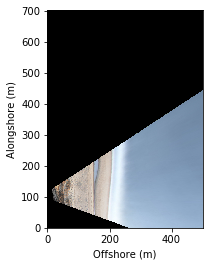

In [29]:
# test rectifying a single image
single_file = impaths[0]
print(single_file)
single_intrinsic = intrinsics_list[0]
single_extrinsic = extrinsics_list[0]
print(type(intrinsics_list))
print(type(single_intrinsic))
print(single_extrinsic)
rectified_single_image = rectifier.rectify_images(metadata, [impaths[1]], [intrinsics_list[1]], [extrinsics_list[1]], local_origin, fs=fs)
plt.imshow(rectified_single_image.astype(np.int))
plt.gca().invert_yaxis()
plt.xlabel('Offshore (m)')
plt.ylabel('Alongshore (m)')

In [12]:
# write a local file
ofile = e+'.rectified.jpg'
imageio.imwrite(ofile,np.flip(rectified_image,0),format='jpg')

In [18]:
if s3:
    # write to the public sfm bucket
    fs2 = fsspec.filesystem('s3', profile='default')
    with fs2.open('s3://cmgp-sfm-public-read-bucket/csherwood/'+ofile,'wb') as fo:
        imageio.imwrite(fo,np.flip(rectified_image,0),format='jpg')

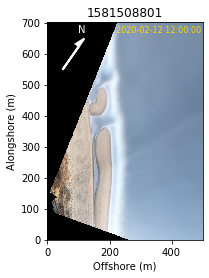

In [16]:
# make an annotated image
plt.imshow( rectified_image.astype(np.int))
plt.gca().invert_yaxis()
plt.xlabel('Offshore (m)')
plt.ylabel('Alongshore (m)')
# make a North arrow
angr = calibration.local_origin['angd']*np.pi/180.
dx = np.cos(angr)*90.
dy = np.sin(angr)*90.
plt.arrow(50,550,dx,dy,linewidth=2,head_width=25,head_length=30,color='white',shape='right')
plt.text(100,670,'N',color='white')
plt.text(220,670,ftime,fontsize=8,color='gold')
plt.title(e)
fp = e+'.rectified.png'
plt.savefig(fp,dpi=200)

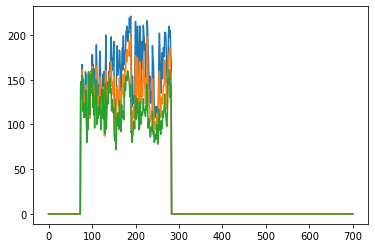

In [17]:
# alongshore profile of RGB values at 
plt.plot(rectified_image[:,60,:])